# SHP2CSV algorithm
## Importing libraries

In [1]:
from shapely.geometry import shape
from shapely.ops import unary_union
import fiona
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from shutil import copyfile
import pandas as pd

## Importing and reading shp file

In [2]:
geoms =[shape(feature['geometry']) for feature in fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp") if feature['geometry'] != None]


## Converting `geoms` into a planar graph

In [3]:
file_info = fiona.open("shp/Bogota_linea/Bogota_linea_holes/Bogota_linea.shp")

In [4]:
res = unary_union(geoms)

## Creating a Graph object in order to print it
this part of the code is not needed, it is just for having an idea of the graph that is going to be exported

In [5]:
G = nx.Graph()
for line in res:
    for seg_start, seg_end in zip(list(line.coords),list(line.coords)[1:]):
        G.add_edge(seg_start, seg_end)

## Plotting the graph

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is dep

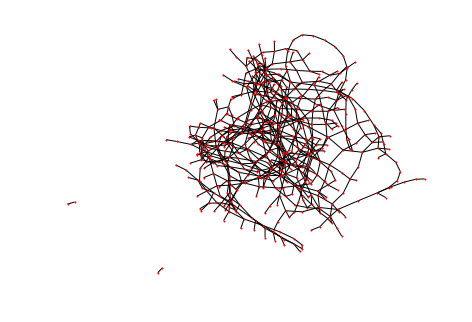

In [6]:
nx.draw(G, node_size=1)
plt.show()

## Creating sets

In [7]:
y = set()
x = set()
lengths = set()

nodes = set()
edges = set()
edges_prime = set()

nodes_norm = list()
edges_norm = set()

## Creating a list of nodes

In [8]:
for line in res:
    for node in line.coords:
        nodes.add((round(node[0],3),round(node[1],3)))
        x.add(round(node[0],3))
        y.add(round(node[1],3))

nodes = list(nodes)

## Normalizing the nodes coordinates

In [9]:
# Getting the max and min for x and y axis
x_max = max(x)
x_min = min(x)
y_max = max(y)
y_min = min(y)

In [10]:
df3 = pd.DataFrame(data=[[x_min,x_max,y_min,y_max]], columns=['x_min','x_max','y_min','y_max'])
df3.to_csv('../../distributions/boundaries.csv', index=False)

In [11]:
# Normalizing

for node in nodes:
    node_norm = (nodes.index(node), [(node[0]-x_min)/(x_max-x_min),(node[1]-y_min)/(y_max-y_min)])
    nodes_norm.append(node_norm)
    
nodes_norm = [(item[0], [round(item[1][0],3), round(item[1][1],3)]) for item in nodes_norm]

## Creating a list of edges

In [12]:
for line in file_info:
    last_coord = None
    for coord in line['geometry']['coordinates']:
        if last_coord != None:
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            edge = ((nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3)))),length,line['properties']['Id'])
            edges_prime.add(edge)
        last_coord = coord
        
    
edges_prime = [edge for edge in edges_prime if edge[0][1] != edge[0][0]]

In [13]:
nodes_with_capacity = list(zip(*edges_prime))[0]
for line in res:
    last_coord = None
    lenght = len(line.coords)
    for coord in line.coords:
        if last_coord != None:
            capacity = 0
            length = ((coord[0]-last_coord[0])**2+(coord[1]-last_coord[1])**2)**0.5
            nodes_connected = (nodes.index((round(last_coord[0],3),round(last_coord[1],3))),nodes.index((round(coord[0],3),round(coord[1],3))))
            if nodes_connected in nodes_with_capacity:
                capacity = edges_prime[nodes_with_capacity.index(nodes_connected)][2]
            elif (nodes_connected[1],nodes_connected[0]) in nodes_with_capacity:
                capacity = edges_prime[nodes_with_capacity.index((nodes_connected[1],nodes_connected[0]))][2]
            
            edge = (nodes_connected,length,capacity)
            edges.add(edge)
        last_coord = coord
        
    
edges = [edge for edge in edges if edge[0][1] != edge[0][0]]

In [14]:
edges_with_capacity = [edge for edge in edges if edge[2] > 0]
edges_prime_with_capacity = [edge for edge in edges_prime if edge[2] > 0]
edges_ignored = [edge for edge in edges_prime_with_capacity if edge[0] not in list(zip(*edges_with_capacity))[0] and (edge[0][1], edge[0][0]) not in list(zip(*edges_with_capacity))[0]]
print("there is still", len(edges_prime_with_capacity) - len(edges_with_capacity),"(",len(edges_ignored), ")", "edges without correct capacity")
assert len(edges_prime_with_capacity) - len(edges_with_capacity) == len(edges_ignored)


there is still 156 ( 156 ) edges without correct capacity


# Solving new streets capacity

In [69]:
A = []
for elems in file_info:
    for coords in elems['geometry']['coordinates']:
        A.append((round(coords[0],3),round(coords[1],3)))
        
B_prime = [b for b in nodes if b not in A]

print("A:", len(A))
print("B:", len(nodes))
print("B':", len(B_prime))

A: 411
B: 407
B': 116


In [73]:
results = []
for b_prime in B_prime:
    # Get B'B'
    b_prime_index = nodes.index(b_prime)
    BB_prime = [edge[0] for edge in edges if b_prime_index in edge[0]] # what about if there is 2 streets crossing over AB? ERROR TODO SOLVE!
    BB_prime = set(node[0] if node[0] != b_prime_index else node[1] for node in BB_prime)
    
    # Checking if b_prime is convex combination 
    results_prime = []
    for a in BB_prime:
        for b in BB_prime:
            if a == b or (len(results_prime) > 0 and ((a,b) in list(zip(*results_prime))[0] or (b,a) in list(zip(*results_prime))[0])):
                continue
            
            if (nodes[b][0]-nodes[a][0]) == 0: lambda1 = 0
            else: lambda1 = (b_prime[0]-nodes[a][0])/(nodes[b][0]-nodes[a][0])
                
            if (nodes[b][1]-nodes[a][1]) == 0: lambda2 = 0
            else: lambda2 = (b_prime[1]-nodes[a][1])/(nodes[b][1]-nodes[a][1])
            
            if lambda1**2 <= 1 and lambda2**2 <= 1:
                # one option, save it with their distances to a linear combination
                x_p = nodes[b][0]-nodes[a][0]
                y_p = nodes[b][1]-nodes[a][1]
                
                x = b_prime[0]-nodes[a][0]
                y = b_prime[1]-nodes[a][1]
                
                lbd = (x_p*x+y_p*y)/(x_p**2+y_p**2)
                d = (x-lbd*x_p)**2 + (y-lbd*y_p)**2
                
                results_prime.append(((a, b), d))
    
    results.append(results_prime)
            

In [74]:
results

[[((293, 179), 2.684563758491352e-08),
  ((179, 45), 2.122279792741811e-05),
  ((45, 207), 3.298969072044318e-08)],
 [((233, 147), 1.5457413248930822e-07),
  ((233, 350), 3.600000000000273e-05),
  ((133, 233), 1.280000000001014e-05),
  ((133, 350), 1.1764705882474515e-07)],
 [((213, 320), 1.1971530249131847e-05),
  ((213, 348), 4.999999999921504e-07),
  ((320, 348), 1.2615384615388942e-05),
  ((320, 349), 3.2232070910863154e-09),
  ((348, 349), 3.379999999998101e-05)],
 [((243, 131), 7.692307691995903e-09),
  ((243, 134), 4.624000000005263e-05),
  ((131, 155), 1.6780821917735063e-05),
  ((155, 243), 3.9194300518205946e-05),
  ((155, 134), 3.684749232080388e-08),
  ((134, 131), 1.468995633181098e-05)],
 [((344, 209), 2.044728434494906e-07),
  ((344, 217), 2.4999999999954526e-05),
  ((217, 209), 2.1113402061849044e-05),
  ((217, 318), 1.2997347480024308e-07)],
 [((82, 52), 7.478913738019583e-05),
  ((82, 134), 2.8500941990489117e-32),
  ((243, 82), 5.607692307692685e-05),
  ((243, 52), 3

## Normalizing the cost of the edges

In [18]:
length_max = max(list(zip(*edges))[1])
length_min = min(list(zip(*edges))[1])

# normalizing length
edges_norm = [(edges.index(edge),edge[0],(edge[1]-length_min)/(length_max-length_min),edge[2]) for edge in edges]

## printing results

In [19]:
nodes_norm

[(0, [0.611, 0.221]),
 (1, [0.596, 0.723]),
 (2, [0.689, 0.303]),
 (3, [0.456, 0.29]),
 (4, [0.166, 0.264]),
 (5, [0.435, 0.303]),
 (6, [0.731, 0.857]),
 (7, [0.497, 0.225]),
 (8, [0.808, 0.792]),
 (9, [0.472, 0.303]),
 (10, [0.622, 0.303]),
 (11, [0.171, 0.316]),
 (12, [0.782, 0.32]),
 (13, [0.435, 0.701]),
 (14, [0.788, 0.861]),
 (15, [0.762, 0.506]),
 (16, [0.819, 0.996]),
 (17, [0.269, 0.481]),
 (18, [0.684, 0.545]),
 (19, [0.637, 0.481]),
 (20, [0.347, 0.468]),
 (21, [0.679, 0.468]),
 (22, [0.601, 0.532]),
 (23, [0.404, 0.494]),
 (24, [0.155, 0.519]),
 (25, [0.394, 0.307]),
 (26, [0.591, 0.887]),
 (27, [0.078, 0.385]),
 (28, [0.741, 0.32]),
 (29, [0.062, 0.372]),
 (30, [0.601, 0.926]),
 (31, [0.72, 0.372]),
 (32, [0.725, 0.9]),
 (33, [0.508, 0.307]),
 (34, [0.72, 0.835]),
 (35, [0.326, 0.701]),
 (36, [0.435, 0.563]),
 (37, [0.373, 0.615]),
 (38, [0.772, 0.589]),
 (39, [0.528, 0.563]),
 (40, [0.534, 0.074]),
 (41, [0.596, 0.537]),
 (42, [0.316, 0.589]),
 (43, [0.534, 0.615]),
 (44,

In [20]:
edges_norm

[(0, (81, 285), 0.1407915303204323, 0),
 (1, (138, 345), 0.07986449352252796, 0),
 (2, (181, 350), 0.21703926139184102, 0),
 (3, (59, 61), 0.09494766843354063, 0),
 (4, (243, 263), 0.10850380789993118, 0),
 (5, (203, 281), 0.10213099529501894, 2),
 (6, (401, 75), 0.11115577013726233, 0),
 (7, (246, 43), 0.18447497486200937, 0),
 (8, (154, 330), 0.3544893338472325, 0),
 (9, (94, 60), 0.09243672044494194, 0),
 (10, (98, 242), 0.06547294192028254, 0),
 (11, (241, 233), 0.11370215176167965, 0),
 (12, (396, 202), 0.04360869935642082, 2),
 (13, (174, 83), 0.056269371169735904, 0),
 (14, (175, 214), 0.2278183426613349, 0),
 (15, (161, 366), 0.1480282317652406, 0),
 (16, (22, 70), 0.15153477639995902, 0),
 (17, (318, 381), 0.12229559864000158, 0),
 (18, (404, 257), 0.03195480399590769, 2),
 (19, (293, 232), 0.22807900936297354, 0),
 (20, (110, 220), 0.1795233791978377, 0),
 (21, (353, 328), 0.2789227409254117, 0),
 (22, (257, 329), 0.02389628282069355, 2),
 (23, (262, 399), 0.12017091532058354

## Exporting results to csv

In [21]:
# Writing csv
import csv

# vertices
with open("vertices.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in nodes_norm:
        writer.writerow([val[0],val[1][0],val[1][1]])
        
# edges
with open("edges.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in edges_norm:
        writer.writerow([val[0], val[1][0], val[1][1], val[2], val[3]])

copyfile('edges.csv', '../../streets/edges.csv');
copyfile('vertices.csv', '../../streets/vertices.csv');